In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import os
from PIL import Image
import matplotlib.pylab as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
import cv2 
import math
#
import keras
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization, Activation
from keras.models import Model
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import TensorBoard
from keras.utils import multi_gpu_model
#
import tensorflow as tf

/usr/local/lib/python3.6/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
# Assign gpu 
os.environ["CUDA_VISIBLE_DEVICES"] = "0,2"

In [2]:
# Reference: https://www.kaggle.com/gimunu/data-augmentation-with-keras-into-cnn
# Load images
train_images = os.listdir("train/")
test_images = os.listdir("test/")
df = pd.read_csv("train.csv")
# Build Table
df["imagepath"] = df["Image"].map( lambda x : "/media/fanglab/DATA/Wei-Tse/Whale_Classifier/train/"+x)
ImageToLabelDict = dict( zip( df.Image, df["Id"]))
df.head()

,Image,Id,imagepath
0,00022e1a.jpg,w_e15442c,/media/fanglab/DATA/Wei-Tse/Whale_Classifier/t...
1,000466c4.jpg,w_1287fbc,/media/fanglab/DATA/Wei-Tse/Whale_Classifier/t...
2,00087b01.jpg,w_da2efe0,/media/fanglab/DATA/Wei-Tse/Whale_Classifier/t...
3,001296d5.jpg,w_19e5482,/media/fanglab/DATA/Wei-Tse/Whale_Classifier/t...
4,0014cfdf.jpg,w_f22f3e3,/media/fanglab/DATA/Wei-Tse/Whale_Classifier/t...


In [30]:
#image are imported with resizing and zero padding 
def imageProcessing( imagepath,name,newfolder):
    #temp=[]
    #for i in range(0,len(df)):
    # open image
    img = cv2.imread(imagepath)
    # size of image
    height, width, channels = img.shape
    # convert gray to RGB
    if channels!=1:
        img=cv.cvtColor(img,cv.COLOR_RGB2GRAY)
    # Float
    img=img.astype(np.float) 
    # padding to the ratio in 1:1, so pick the max between widtrh and height
    if width > height:
        newsize=width
    else:
        newsize=height
    if newsize%2==1:
        newsize=newsize+1
    # if size is smaller than 896, the input size od new image should be 896
    if newsize<896:
        newsize=896
    #New image
    new_img = np.zeros((newsize,newsize,3))
    # zero padding
    midh=int(newsize/2)
    whalf=int(math.floor(width/2))
    hhalf=int(math.floor(newsize/2))
    # Resize old images to prevent from error
    img=cv2.resize(img,((whalf)*2,(hhalf)*2))
    new_img[(midh-hhalf):(midh+(hhalf)),\
            (midh-whalf):(midh+(whalf)),:]=img
    #resize image TO 896 X 896
    new_img=cv2.resize(new_img,(896,896))
    new_img=new_img.astype(np.float) 
    new_img=(new_img-new_img.min())/(new_img.max()-new_img.min())
    new_img=new_img*255
    #Save
    cv2.imwrite(newfolder+'/'+name,new_img)
for i in range(0,9792):
    imageProcessing(df.imagepath[i],df.Image[i],'AutoEncoder_Data/Test_new2')

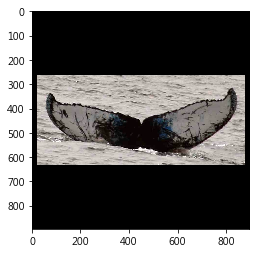

In [3]:
# Show images after zero padding
img = cv2.imread('AutoEncoder_Data/train/Train'+df.Image[20])
height, width, channels = img.shape
plt.imshow(img)
plt.show()


In [212]:
# Data Augmentation
batch_size = 32
seednum = 1

#generator for training
train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=.15,
    height_shift_range=.15,
    horizontal_flip=True)

trainD = train_gen.flow_from_directory(
        'AutoEncoder_Data/train/',
        class_mode="input",
        target_size=(896, 896),
        color_mode='grayscale',
        batch_size=batch_size,
        seed=seednum)
# generator for testing
test_datagen = ImageDataGenerator(rescale=1./255)

testD= test_datagen.flow_from_directory(
        'AutoEncoder_Data/test/',
        target_size=(896, 896),
        batch_size=batch_size,
        color_mode='grayscale',
        class_mode="input",
        seed=seednum+1)

Found 15648 images belonging to 1 classes.
Found 3936 images belonging to 1 classes.


In [226]:
# Build a Convolutional AutoEncoder 
# Input size is 896 x 896
# The encoded size is 224 x 224
# Reference: https://blog.keras.io/building-autoencoders-in-keras.html

# Input image Size
input_img = Input(shape=(896, 896, 1))  # adapt this if using `channels_first` image data format
# Decoder
x =Conv2D(16, (3, 3),padding='same')(input_img)
x=BatchNormalization()(x)
x=Activation('relu')(x)
x=Conv2D(16 ,(3, 3),padding='same')(x)
x=BatchNormalization()(x)
x=Activation('relu')(x)
x=MaxPooling2D((2, 2), padding='same')(x)
#
x=Conv2D(8 ,(3, 3),padding='same')(x)
x=BatchNormalization()(x)
x=Activation('relu')(x)
x=Conv2D(3 ,(3, 3),padding='same')(x)
x=BatchNormalization()(x)
x=Activation('relu')(x)
encoded=MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (224, 224, 3) 

#Encoder
x=Conv2D(8, (3, 3), padding='same')(encoded)
x=BatchNormalization()(x)
x=Activation('relu')(x)
x=Conv2D(8, (3, 3), padding='same')(x)
x=BatchNormalization()(x)
x=Activation('relu')(x)
x=UpSampling2D((2, 2))(x)
#
x=Conv2D(16, (3, 3), padding='same')(x)
x=BatchNormalization()(x)
x=Activation('relu')(x)
x=Conv2D(16, (3, 3), padding='same')(x)
x=BatchNormalization()(x)
x=Activation('relu')(x)
x=UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

#Define the input and ouput
autoencoder = Model(input_img, decoded)
# optimizer 
ot=keras.optimizers.Adam(lr=0.5, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.95, amsgrad=False)

In [227]:
epochsnum = 20
#Set model trained with 2 gpus 
autoencoder = multi_gpu_model(autoencoder, gpus=2)
#Compile the model
autoencoder.compile(optimizer=ot, loss='mean_squared_error')
# Because I use multiple gpus, the output will look strange
# You can comment #autoencoder = multi_gpu_model(autoencoder, gpus=2) to check layers
autoencoder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_74 (InputLayer)           (None, 896, 896, 1)  0                                            
__________________________________________________________________________________________________
lambda_93 (Lambda)              (None, 896, 896, 1)  0           input_74[0][0]                   
__________________________________________________________________________________________________
lambda_94 (Lambda)              (None, 896, 896, 1)  0           input_74[0][0]                   
__________________________________________________________________________________________________
model_116 (Model)               (None, 896, 896, 1)  8664        lambda_93[0][0]                  
                                                                 lambda_94[0][0]                  
__________

In [228]:
# Train
# Note that if steps_per_epoch and validation_steps are not integer, error happends
# file_length%batch_size should be 0
autoencoder.fit_generator(trainD,
                epochs=epochsnum,
                verbose=1,
                shuffle=True,
                validation_data=testD,
                steps_per_epoch=9792//batch_size,
                validation_steps=9792//batch_size,
                callbacks=[TensorBoard(log_dir='/tmp/trainae5')])

Epoch 1/20
306/306 [==============================] - 1009s 3s/step - loss: 0.0193 - val_loss: 0.0102
Epoch 2/20
306/306 [==============================] - 992s 3s/step - loss: 0.0086 - val_loss: 0.0084
Epoch 3/20
306/306 [==============================] - 982s 3s/step - loss: 0.0071 - val_loss: 0.0085
Epoch 4/20
306/306 [==============================] - 969s 3s/step - loss: 0.0062 - val_loss: 0.0076
Epoch 5/20
306/306 [==============================] - 976s 3s/step - loss: 0.0055 - val_loss: 0.0075
Epoch 6/20
306/306 [==============================] - 961s 3s/step - loss: 0.0050 - val_loss: 0.0063
Epoch 7/20
306/306 [==============================] - 964s 3s/step - loss: 0.0045 - val_loss: 0.0050
Epoch 8/20
306/306 [==============================] - 984s 3s/step - loss: 0.0043 - val_loss: 0.0044
Epoch 9/20
306/306 [==============================] - 975s 3s/step - loss: 0.0040 - val_loss: 0.0039
Epoch 10/20
306/306 [==============================] - 970s 3s/step - loss: 0.0038 - val_l

In [4]:
# Get layers from multiple gpu
model = autoencoder.get_layer('model_116')
# Save
model.save('autoencoder.h5')

NameError: name 'autoencoder' is not defined

In [267]:
# Plot the result of Autoencoder
# Load Model
from keras.models import load_model
model = load_model('autoencoder.h5')
# optimizer If you do not use multiple gpu, you don't need to do so
ot=keras.optimizers.Adam(lr=0.5, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.95, amsgrad=False)
#Compile the model If you do not use multiple gpu, you don't need to do so
model.compile(optimizer=ot, loss='mean_squared_error')

/home/fanglab/.local/lib/python3.6/site-packages/keras/models.py:255: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [268]:
# Read an image
img=cv2.imread('AutoEncoder_Data/test/no_species2/1ab3d011.jpg.png')
# Size
height, width, channels = img.shape
# RGB to Gray
newimg=cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
# Uint8 to Float
newimg=newimg.astype(np.float)
# Normalize
newimg=newimg/255
# equal to model input 
newimg=newimg.reshape((1,896,896,1))
# Predict
predictimage=model.predict(newimg)
# Reshape
predictimage=predictimage.reshape((896,896))

In [ ]:
model.summary()

In [269]:
# Extract Features from max_pooling2d_108
# Set model
model_224 = Model(inputs=model.input, outputs=model.get_layer('max_pooling2d_108').output)

In [ ]:
# Predict
predictimage=model.predict(newimg)
# Reshape
predictimage=predictimage.reshape((896,896))
# Predict Encoded image
predictimage_224=model_224.predict(newimg)
# Reshpae
predictimage_224=predictimage_224.reshape((224,224,3))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


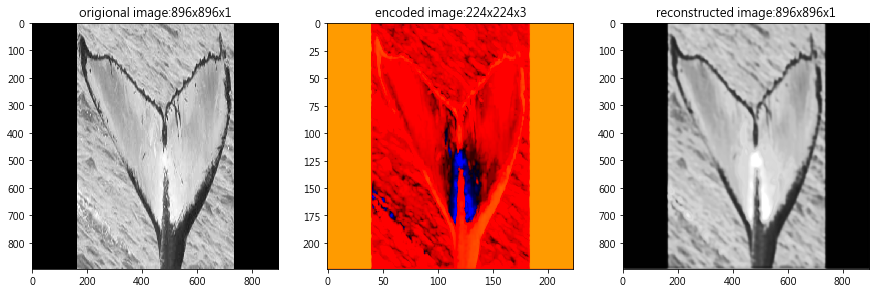

In [260]:
# Plot Reconstruced Image
plt.figure(figsize=(15, 15))
# Origional Input Image, set Colormap = Gray
plt.subplot(131)
plt.imshow(newimg.reshape(896,896)/255,cmap='gray')
plt.title('origional image:896x896x1')
# Encoded Image
plt.subplot(132)
plt.imshow(predictimage_224)
plt.title('encoded image:224x224x3')
# Decoded Image
plt.subplot(133)
plt.imshow(predictimage,cmap='gray')
plt.title('reconstructed image:896x896x1')
plt.show()

In [294]:
# Process Data with autoencoder
def encodedimage(path,name,newfolder):
    name=test_images[i]
    # open image
    img = cv2.imread(path)
    # size of image
    height, width, channels = img.shape
    # convert gray to RGB
    if channels!=1:
        img=cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    # Uint8 to Gray
    img=img.astype(np.float) 
    # padding to the ratio in 1:1, so pick the max between widtrh and height
    if width > height:
        newsize=width
    else:
        newsize=height
    if newsize%2==1:
        newsize=newsize+1
    # if size is smaller than 896, the input size od new image should be 896
    if newsize<896:
        newsize=896
    #New image
    new_img = np.zeros((newsize,newsize))
    # zero padding
    midh=int(newsize/2)
    whalf=int(math.floor(width/2))
    hhalf=int(math.floor(newsize/2))
    # Resize old images toi prevent from error
    img=cv2.resize(img,((whalf)*2,(hhalf)*2))
    new_img[(midh-hhalf):(midh+(hhalf)),\
            (midh-whalf):(midh+(whalf))]=img
    #resize image TO 896 X 896
    new_img=cv2.resize(new_img,(896,896))
    new_img=new_img.astype(np.float) 
    new_img=(new_img-new_img.min())/(new_img.max()-new_img.min())
    new_img=new_img.reshape((1,896,896,1))
    # Encoded by autoencoder
    encodedimage=model_224.predict(new_img)
    # Reshape encoded image
    encodedimage=encodedimage.reshape((224,224,3))
    # Noramlize
    for j in range(0,3):
        maxi=encodedimage[:,:,j].max()
        mini=encodedimage[:,:,j].min()
        encodedimage[:,:,j]=(encodedimage[:,:,j]-mini)/(maxi-mini)*255
    # whether dir exists
    if os.path.isdir(newfolder)==False:
        os.mkdir(newfolder)
    #Save
    cv2.imwrite(newfolder+'/'+name,encodedimage)
trainos = os.listdir('train/')
for i in range(0,len(trainos)):
    encodedimage('train/'+trainos[i],trainos[i],'CNN_TransferL/train/'+ImageToLabelDict[trainos[i]])

/home/fanglab/.local/lib/python3.6/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in true_divide


In [3]:
# LabelEncoder + OnehotEncoder
class LabelOneHotEncoder():
    def __init__(self):
        self.ohe = OneHotEncoder()
        self.le = LabelEncoder()
    def fit_transform(self, x):
        features = self.le.fit_transform( x)
        return self.ohe.fit_transform( features.reshape(-1,1))
    def transform( self, x):
        return self.ohe.transform( self.la.transform( x.reshape(-1,1)))
    def inverse_tranform( self, x):
        return self.le.inverse_transform( self.ohe.inverse_tranform( x))
    def inverse_labels( self, x):
        return self.le.inverse_transform( x)
#constructing class weights
WeightFunction = lambda x : 1./x**0.75
ClassLabel2Index = lambda x : lohe.le.inverse_tranform([[x]])

In [4]:
# Keras use alphabery order for one-hot enciding
# Sklearn also use alphabery order for one-hot enciding
# So, I guess my weighting order can match the order in imageDataGenrator.flow_from_dictionary
# But, I did not prove it
lohe = LabelOneHotEncoder()
# find the label name
y = list(map(ImageToLabelDict.get, train_images))
# Encode label
y_cat = lohe.fit_transform(y)
#
CountDict = dict( df["Id"].value_counts())
# set the weighting dictionary 
class_weight_dic = {lohe.le.transform( [image_name])[0]:WeightFunction(count) for image_name, count in CountDict.items()}

In [16]:
lohe.le.transform(['w_002222a'])

array([3])

In [4]:
# Build CNN imagedatabase

batch_size = 64
seednum = 1

#generator for training
# the folder name will be though as label name if class_mode="categorical"
# And keras will use folder name for one hot encoding
# let's why alphabery order is important

# Data Augmentation
train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=.15,
    height_shift_range=.15,
    horizontal_flip=True)

#data from specific path
trainD = train_gen.flow_from_directory(
        'CNN_TransferL/train/',
        class_mode="categorical",
        batch_size=batch_size,
        target_size=(224, 224),
        seed=seednum,
        shuffle=False)

Found 9850 images belonging to 4251 classes.


In [10]:
# Import VGG19
from keras.applications.vgg19 import VGG19
vggorigin = VGG19(weights='imagenet', include_top=True)
predictions = Dense(4251, activation='softmax')(vggorigin.get_layer('fc2').output)
VGG_TL=Model(inputs=vggorigin.input, outputs=predictions)
# transfer learning only update FC layers
for layerG in VGG_TL.layers[:24]:
   layerG.trainable = False

In [11]:
# optimizer 
ot=keras.optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.95, amsgrad=False)
#Set model trained with 2 gpus 
VGG_TL = multi_gpu_model(VGG_TL, gpus=2)
#Compile the model
VGG_TL.compile(optimizer=ot, loss='categorical_crossentropy', metrics=['accuracy'])
# Because I use multiple gpus, the output will look strange
# You can comment #multi_gpu_model(autoencoder, gpus=2) to check layers
VGG_TL.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 224, 224, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 224, 224, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
model_2 (Model)                 (None, 4251)         156986587   lambda_1[0][0]                   
                                                                 lambda_2[0][0]                   
__________

In [12]:
# Train! 
# Note that shuffle should be false because I use class_weight
# 9850 is the size of trai data
# the num of epoch
epochsnum = 10
VGG_TL.fit_generator(trainD,
          steps_per_epoch=9850//batch_size,
          epochs=epochsnum,
          verbose=1,
          class_weight=class_weight_dic,
          shuffle=False)
# Since Class imbalance, auccuray is very low

Epoch 1/10
153/153 [==============================] - 115s 754ms/step - loss: 7.9946 - acc: 0.0762
Epoch 2/10
153/153 [==============================] - 114s 744ms/step - loss: 7.9862 - acc: 0.0827
Epoch 3/10
153/153 [==============================] - 115s 749ms/step - loss: 7.9998 - acc: 0.0827
Epoch 4/10
153/153 [==============================] - 114s 748ms/step - loss: 7.9874 - acc: 0.0827
Epoch 5/10
153/153 [==============================] - 114s 743ms/step - loss: 7.9898 - acc: 0.0827
Epoch 6/10
153/153 [==============================] - 113s 738ms/step - loss: 7.9818 - acc: 0.0827
Epoch 7/10
153/153 [==============================] - 114s 747ms/step - loss: 7.9787 - acc: 0.0827
Epoch 8/10
153/153 [==============================] - 114s 743ms/step - loss: 7.9735 - acc: 0.0827
Epoch 9/10
153/153 [==============================] - 115s 749ms/step - loss: 7.9996 - acc: 0.0827
Epoch 10/10
153/153 [==============================] - 115s 748ms/step - loss: 7.9862 - acc: 0.0827


In [13]:
# Get layers from multiple gpu
VGG_TLF = VGG_TL.get_layer('model_2')
# Save
VGG_TLF.save('VGG_TL.h5')

In [24]:
# Train new model with Resnet50
from keras.applications.resnet50 import ResNet50
# Import Resnet 
ResNet50model = ResNet50(weights='imagenet', include_top=True)

In [26]:
# Extract features from flatten_6 layer
# Add to new FC layer 
x = Dense(8096, activation='relu')(ResNet50model.get_layer('flatten_6').output)
# Final Output Layer 4251 is # of categories
predictions = Dense(4251, activation='softmax')(x)
# Connect all layers
ResNet50model_TL=Model(inputs=ResNet50model.input, outputs=predictions)

In [27]:
# the length of layers
len(ResNet50model_TL.layers)

178

In [29]:
# transfer learning only update FC layers
for layerG in ResNet50model_TL.layers[:177]:
   layerG.trainable = False

In [30]:
# optimizer 
ot=keras.optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.95, amsgrad=False)
#Set model trained with 2 gpus 
ResNet50model_TL = multi_gpu_model(ResNet50model_TL, gpus=2)
#Compile the model
ResNet50model_TL.compile(optimizer=ot, loss='categorical_crossentropy', metrics=['accuracy'])
# Because I use multiple gpus, the output will look strange
# You can comment #multi_gpu_model(autoencoder, gpus=2) to check layers
#VGG_TL.summary()

In [31]:
# Train
epochsnum = 10
ResNet50model_TL.fit_generator(trainD,
          steps_per_epoch=9850//batch_size,
          epochs=epochsnum,
          verbose=1,
          class_weight=class_weight_dic,
          shuffle=False)

Epoch 1/10
153/153 [==============================] - 117s 766ms/step - loss: 6.3379 - acc: 0.0763
Epoch 2/10
153/153 [==============================] - 110s 721ms/step - loss: 3.9345 - acc: 0.0854
Epoch 3/10
153/153 [==============================] - 112s 731ms/step - loss: 3.3193 - acc: 0.1146
Epoch 4/10
153/153 [==============================] - 111s 726ms/step - loss: 3.0050 - acc: 0.1450
Epoch 5/10
153/153 [==============================] - 112s 733ms/step - loss: 2.8156 - acc: 0.1676
Epoch 6/10
153/153 [==============================] - 111s 727ms/step - loss: 2.6833 - acc: 0.1960
Epoch 7/10
153/153 [==============================] - 112s 735ms/step - loss: 2.5664 - acc: 0.2216
Epoch 8/10
153/153 [==============================] - 113s 737ms/step - loss: 2.4838 - acc: 0.2438
Epoch 9/10
153/153 [==============================] - 112s 733ms/step - loss: 2.4282 - acc: 0.2640
Epoch 10/10
153/153 [==============================] - 113s 737ms/step - loss: 2.3625 - acc: 0.2834


In [32]:
# Train for 15 epoches continoously since it can be better
epochsnum = 15
ResNet50model_TL.fit_generator(trainD,
          steps_per_epoch=9850//batch_size,
          epochs=epochsnum,
          verbose=1,
          class_weight=class_weight_dic,
          shuffle=False)

Epoch 1/15
153/153 [==============================] - 113s 737ms/step - loss: 2.3147 - acc: 0.3025
Epoch 2/15
153/153 [==============================] - 111s 727ms/step - loss: 2.2716 - acc: 0.3189
Epoch 3/15
153/153 [==============================] - 117s 765ms/step - loss: 2.2460 - acc: 0.3329
Epoch 4/15
153/153 [==============================] - 116s 756ms/step - loss: 2.2024 - acc: 0.3483
Epoch 5/15
153/153 [==============================] - 112s 733ms/step - loss: 2.1694 - acc: 0.3638
Epoch 6/15
153/153 [==============================] - 119s 778ms/step - loss: 2.1417 - acc: 0.3774
Epoch 7/15
153/153 [==============================] - 115s 752ms/step - loss: 2.1168 - acc: 0.3853
Epoch 8/15
153/153 [==============================] - 111s 723ms/step - loss: 2.0946 - acc: 0.3959
Epoch 9/15
153/153 [==============================] - 111s 724ms/step - loss: 2.0782 - acc: 0.4060
Epoch 10/15
153/153 [==============================] - 112s 729ms/step - loss: 2.0507 - acc: 0.4147
Epoch 11/

In [33]:
# Train for 30 epoches continoously since it can be better
epochsnum = 30
ResNet50model_TL.fit_generator(trainD,
          steps_per_epoch=9850//batch_size,
          epochs=epochsnum,
          verbose=1,
          class_weight=class_weight_dic,
          shuffle=False)

Epoch 1/30
153/153 [==============================] - 112s 733ms/step - loss: 1.9571 - acc: 0.4560
Epoch 2/30
153/153 [==============================] - 115s 751ms/step - loss: 1.9399 - acc: 0.4593
Epoch 3/30
153/153 [==============================] - 111s 725ms/step - loss: 1.9311 - acc: 0.4635
Epoch 4/30
153/153 [==============================] - 111s 724ms/step - loss: 1.9184 - acc: 0.4725
Epoch 5/30
153/153 [==============================] - 111s 723ms/step - loss: 1.9045 - acc: 0.4772
Epoch 6/30
153/153 [==============================] - 110s 718ms/step - loss: 1.8884 - acc: 0.4791
Epoch 7/30
153/153 [==============================] - 110s 717ms/step - loss: 1.8817 - acc: 0.4798
Epoch 8/30
153/153 [==============================] - 111s 727ms/step - loss: 1.8731 - acc: 0.4874
Epoch 9/30
153/153 [==============================] - 113s 737ms/step - loss: 1.8650 - acc: 0.4862
Epoch 10/30
153/153 [==============================] - 112s 732ms/step - loss: 1.8531 - acc: 0.4903
Epoch 11/

In [34]:
# Train for 20 epoches continoously since it can be better
epochsnum = 30
ResNet50model_TL.fit_generator(trainD,
          steps_per_epoch=9850//batch_size,
          epochs=epochsnum,
          verbose=1,
          class_weight=class_weight_dic,
          shuffle=False)

Epoch 1/30
153/153 [==============================] - 112s 731ms/step - loss: 1.7091 - acc: 0.5283
Epoch 2/30
153/153 [==============================] - 112s 730ms/step - loss: 1.7071 - acc: 0.5272
Epoch 3/30
153/153 [==============================] - 113s 735ms/step - loss: 1.7045 - acc: 0.5340
Epoch 4/30
153/153 [==============================] - 113s 737ms/step - loss: 1.6981 - acc: 0.5277
Epoch 5/30
153/153 [==============================] - 113s 736ms/step - loss: 1.6961 - acc: 0.5301
Epoch 6/30
153/153 [==============================] - 112s 731ms/step - loss: 1.6883 - acc: 0.5314
Epoch 7/30
153/153 [==============================] - 114s 744ms/step - loss: 1.6792 - acc: 0.5334
Epoch 8/30
153/153 [==============================] - 114s 745ms/step - loss: 1.6754 - acc: 0.5384
Epoch 9/30
153/153 [==============================] - 111s 727ms/step - loss: 1.6762 - acc: 0.5384
Epoch 10/30
153/153 [==============================] - 110s 721ms/step - loss: 1.6672 - acc: 0.5392
Epoch 11/

In [36]:
ResNet50model_TL.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
lambda_3 (Lambda)               (None, 224, 224, 3)  0           input_10[0][0]                   
__________________________________________________________________________________________________
lambda_4 (Lambda)               (None, 224, 224, 3)  0           input_10[0][0]                   
__________________________________________________________________________________________________
model_4 (Model)                 (None, 4251)         74596763    lambda_3[0][0]                   
                                                                 lambda_4[0][0]                   
__________

In [37]:
# Get layers from multiple gpu
ResNet50model_TLF = ResNet50model_TL.get_layer('model_4')
# Save
ResNet50model_TLF.save('ResNet50model_TL.h5')

In [ ]:
# Load Model
from keras.models import load_model
model = load_model('ResNet50model_TL.h5')

In [ ]:
# Let's Predict!
import warnings
from os.path import split
from keras.preprocessing import image

In [ ]:
with open("sample_submission.csv","w") as f:
    with warnings.catch_warnings():
        f.write("Image,Id\n")
        warnings.filterwarnings("ignore",category=DeprecationWarning)
        for image in test_images:
            img = ImportImage( image)
            x = img.astype( "float32")
            #applying preprocessing to test images
            x = image_gen.standardize( x.reshape(1,SIZE,SIZE))
            
            y = model.predict_proba(x.reshape(1,SIZE,SIZE,1))
            predicted_args = np.argsort(y)[0][::-1][:5]
            predicted_tags = lohe.inverse_labels( predicted_args)
            image = split(image)[-1]
            predicted_tags = " ".join( predicted_tags)
            f.write("%s,%s\n" %(image, predicted_tags))

In [ ]:
img = ImportImage( image)
x = img.astype( "float32")
#applying preprocessing to test images
x =x.reshape(1,224,224,3)
y = model.predict_proba(x)